In [1]:
# Our numerical workhorse
import numpy as np
import scipy.special
import pandas as pd

# Import pyplot for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Beeswarm plots
import beeswarm as bs

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [9]:
# let's load the data
df = pd.read_csv('data/hiv_data.csv',comment='#')
print (df)

    Days after administration  RNA copies per mL
0                      0.0000           106100.0
1                      0.0831            93240.0
2                      0.1465           166720.0
3                      0.2587           153780.0
4                      0.4828           118800.0
5                      0.7448           116900.0
6                      0.9817           109570.0
7                      1.2563           111350.0
8                      1.4926            74388.0
9                      1.7299            83291.0
10                     1.9915            66435.0
11                     3.0011            35408.0
12                     4.0109            21125.0
13                     5.0090            20450.0
14                     5.9943            15798.0
15                     7.0028             4785.2


## Problem 3.3a: Regression

According to the problem statement, the viral load $V(t)$ can be modeled as 

$$V(t,c,\delta)=V_0e^{−ct}+\frac{cV_0}{c−δ}\left[\frac{c}{c−δ}(e^{−δt}−e^{−ct})−δte^{−ct}\right]$$

Where $V_0$ is the initial viral load, $t$ is the time, $\delta$ is the rate at which infected cells die, and $c$ is the rate at which viruses are cleared by the drug. Assuming that the RNA copies per mL is proportional to the viral load, we can perform Bayesian regression. 

As always, we start with Bayes' Theorem:

$$P(\mathbf{p}|D,I) = \frac{P(D|\mathbf{p},I)P(\mathbf{p}|I)}{P(D|I)}$$

If we assume that each measurement in $D$ has an identically and Gaussian-distributed error with variance $\sigma^2$ and mean given by the model, then the likelihood is defined as:

$$P(D|\delta,c,\sigma,I) = \prod \frac{1}{\sqrt{2\pi\sigma^2}}\text{exp}\left[\frac{-\left(V(t)-V(t,c,\delta)\right)^2}{2\sigma^2}\right]$$

The log likelihood is then:

$$ \text{log}P(D|\delta,c,\sigma,I) = \sum \text{log}\frac{1}{\sqrt{2\pi\sigma^2}} + \sum \left[\frac{-\left(V(t)-V(t,c,\delta)\right)^2}{2\sigma^2}\right]$$

To compute the posterior, we can assume uniform priors for $c$ and $\delta$ and a Jeffrey's prior for $\sigma$ so that the posterior is:

$$P(c,\delta,\sigma|D,I) \propto \frac{1}{\sigma^{n+1}}\text{exp}\left[-\frac{1}{2\sigma^2}\sum\left(V(t)-V(t,c,\delta)\right)^ 2\right]$$

We don't care about the distribution for $\sigma$, so we can marginalize it to arrive at an (unnormalized) Student-T distribution for the posterior over $c$ and $\delta$. 

$$P(c,\delta|D,I) \propto \left[\sum(V(t)-V(t,c,\delta))\right]^{-\frac{n}{2}}$$

In [55]:
# Let's code the functions for V(t,c,delta) and the log posterior

def V (p,V0,t):
    """
    Calculate V(t,c,delta)
    """
    c, delta = p
    return V0*np.exp(-c*t) + c*V0/(c-delta)*(c/(c-delta)*(np.exp(-delta*t) - np.exp(-c*t)) - delta*t*np.exp(-c*t))

def log_post (p,V0,t,Vs):
    """
    Calculate the log posterior
    """
    # Unpack parameters
    c, delta = p
    
    # Theoretical spindle length
    V_theor = V(p, V0, t)
    return -len(Vs) / 2 * np.log(np.sum((Vs - V_theor)**2))
#print (V((0.002,0.001),106100,df['Days after administration'][1:-1]))

## 3.3b: Plotting the posterior

/Applications/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


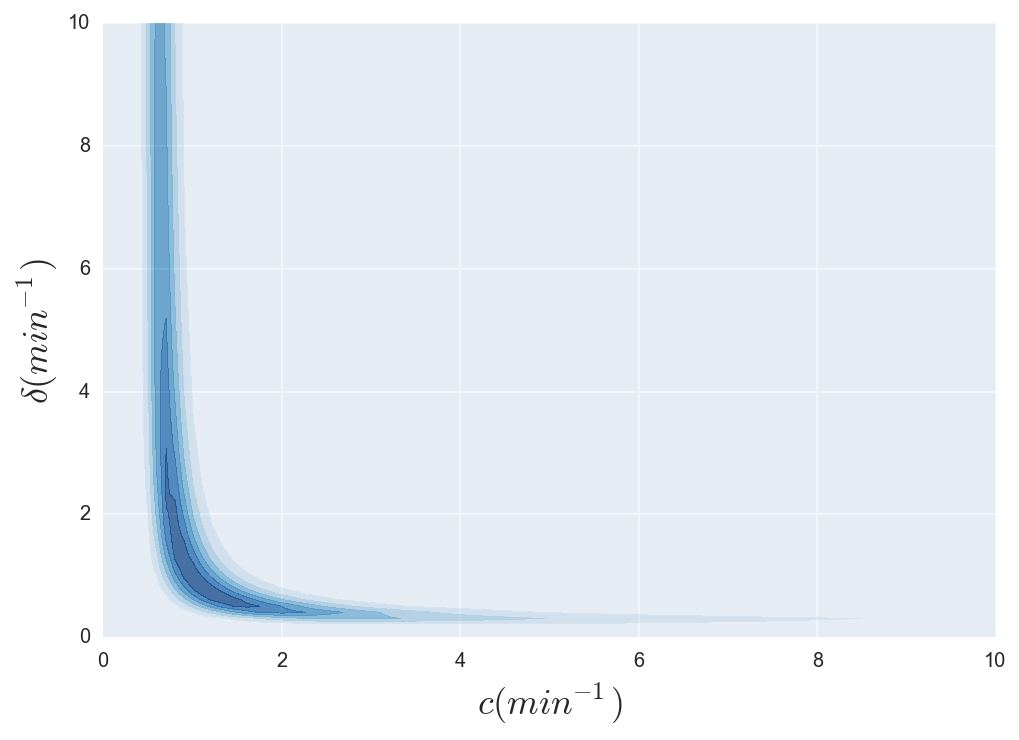

In [65]:
V0 = df[df['Days after administration']==0.0]['RNA copies per mL'].loc[0]
# Parameter values to plot
c = np.linspace(2e-3, 10, 100)
delta = np.linspace(1e-3, 10.001, 100)
# Make a grid
cc, dd = np.meshgrid(c, delta)

# Compute log posterior
log_posterior = np.empty_like(cc)
for j in range(len(c)):
    for i in range(len(delta)):
        log_posterior[i, j] = log_post(np.array([cc[i,j], dd[i,j]]),
                                       V0,
                                       df['Days after administration'][1:-1],
                                       df['RNA copies per mL'][1:-1])

# Get things to scale better
log_posterior -= log_posterior.max()
# Plot the results
plt.contourf(cc, dd, np.exp(log_posterior), cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel(r'$c (min^{-1})$')
plt.ylabel(r'$\delta (min^{-1})$')

There appears to be two serious issues in the estimation of of $c$ and $\delta$. First, the theoretical equation for $V(t)$ is undefined when $c = \delta$. As a result of the $c-\delta$ in the denominator, the posterior is very assymetrical. The peak values lie at either small values of $delta$, small values of $c$, or both. This means that there are many values of $c$ and $\delta$ that are individually are plausible, are not plausible together. 